# Initiate libraries

In [1]:
library("tidyverse")
library("pheatmap")
library("CancerRNASig")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count




# Hyperparameters

In [2]:
normalization <- "vst"  # "vst" or "uqnorm"
correlation_method <- "pearson"  # "pearson", "spearman" or "kendall"

# Data import
To demonstate the use of DESeqDataSetFromMatrix, we will read in count data from the pasilla package.
We read in a count matrix, which we will name `cts`, and the sample information table, which we will name `coldata`.

In [3]:
# Load the counts matrix
cts <- read.csv(file = paste0("data/PDAC_MICRODISSEC_NAIF/rna_seq_selected_", normalization, ".csv"),
                row.names = 1) |>
  as.matrix()

# load the microdissection densities table
densities <- read.csv(file = "data/MALDI_IHC/microdissection_densities.csv", row.names = 1)

## Verify the integrity between the counts matrix and the density table

In [4]:
# Check again if the names are the same regardless of the order
all(rownames(densities) %in% colnames(cts))

[1] TRUE

In [5]:
# Reorder the densities table to match the order of the counts matrix
densities <- densities[colnames(cts), ]

# Check again if order is the same
all(rownames(densities) == colnames(cts))

[1] TRUE

## Transform the gene ids into gene symbols

In [6]:
# Load the gene annotations table
geneannot <- read.delim("data/PDAC_MICRODISSEC_NAIF/geneAnnot.tsv", sep = "\t")

# Transform the gene ids into gene symbols using the annotation table
gene_symbols <- geneannot$GeneName[match(rownames(cts), geneannot$GeneID)]

## Apply mcp counts to get idea about the immune cells abondance

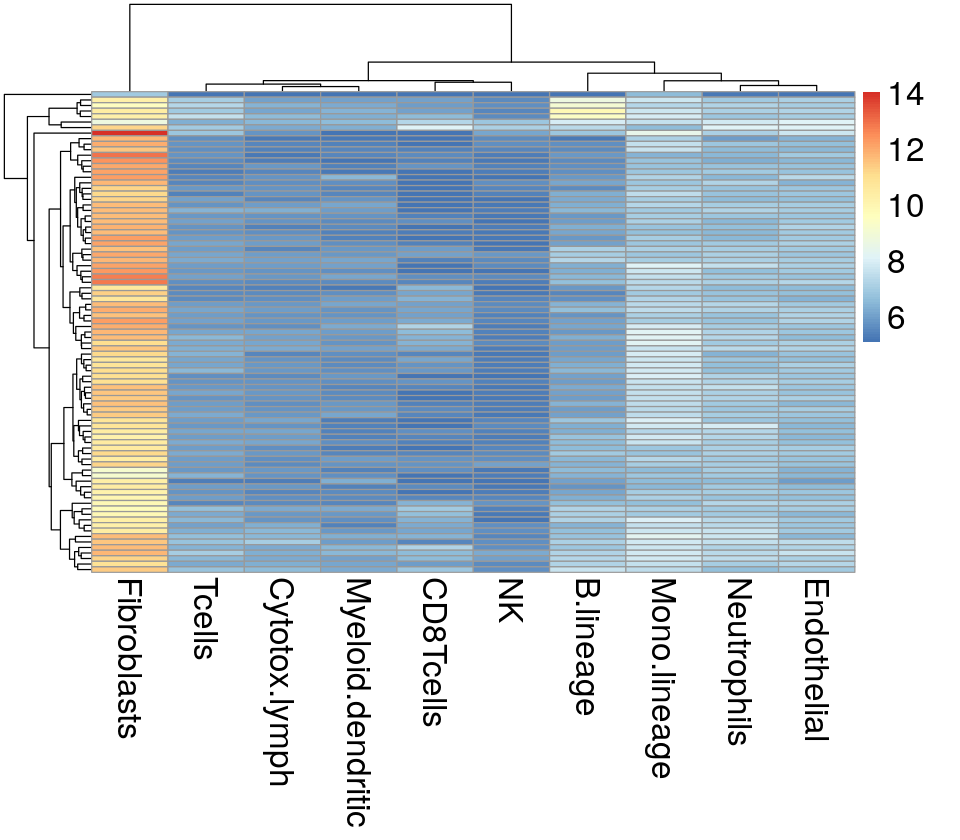

In [7]:
# Apply the mcpcounts on the normalized counts
immuno_counts <- mcpcount(newexp = cts, geneSymbols = gene_symbols)

# Draw a heatmap of the correlations
options(repr.plot.width = 8, repr.plot.height = 7)
immuno_counts |>
  pheatmap(show_rownames = FALSE,
           fontsize = 20)

## Remove the densities out of the lesion

In [8]:
# Filter out the densities out of the lesion (Lesion < 0.5)
cts <- cts[, densities$Lesion >= 0.5]
densities <- densities[densities$Lesion >= 0.5, ]

# Filter out the densities with defects in the microdissection (Defect > 0.1)
cts <- cts[, densities$Defect <= 0.1]
densities <- densities[densities$Defect <= 0.1, ]

# Drop the densities columns Lesion and Defects
densities <- densities[, !(colnames(densities) %in% c("Lesion", "Defects"))]

In [9]:
# count the nan values
sum(is.na(cts))
sum(is.na(densities))

[1] 0

[1] 0

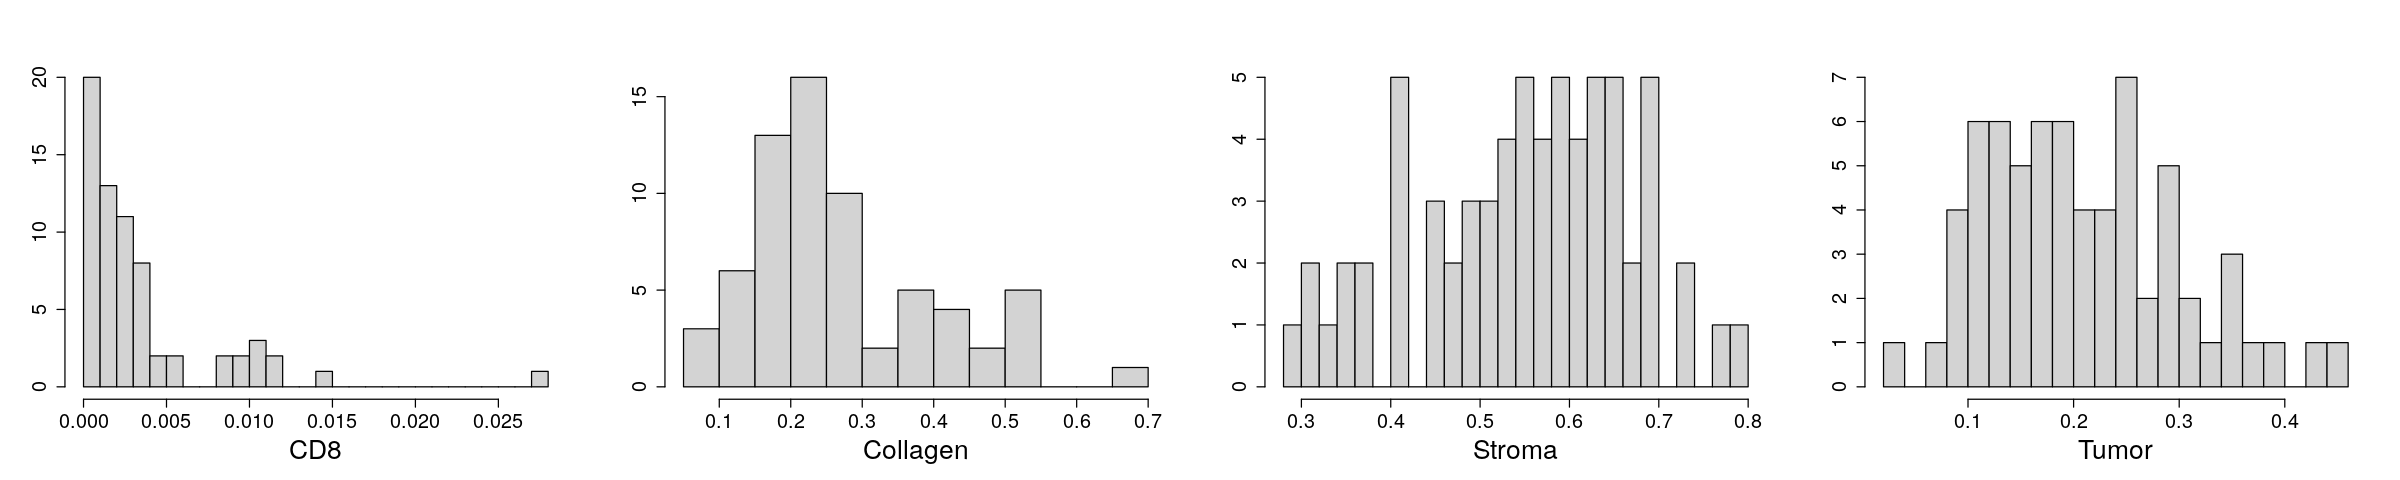

In [10]:
# Draw a histogram of the densities
options(repr.plot.width = 20, repr.plot.height = 4)
par(mfrow = c(1, 4))

for (i in seq_along(colnames(densities))){
  hist(densities[, i],
       ylab = "",
       xlab = colnames(densities)[i],
       breaks = 20,
       main = "",
       cex.axis = 1.5,
       cex.lab = 2)
}

## Study the correlations between the microdissection densities and the genes counts

Warning message in cor(x = t(cts), y = densities, method = correlation_method):
“the standard deviation is zero”


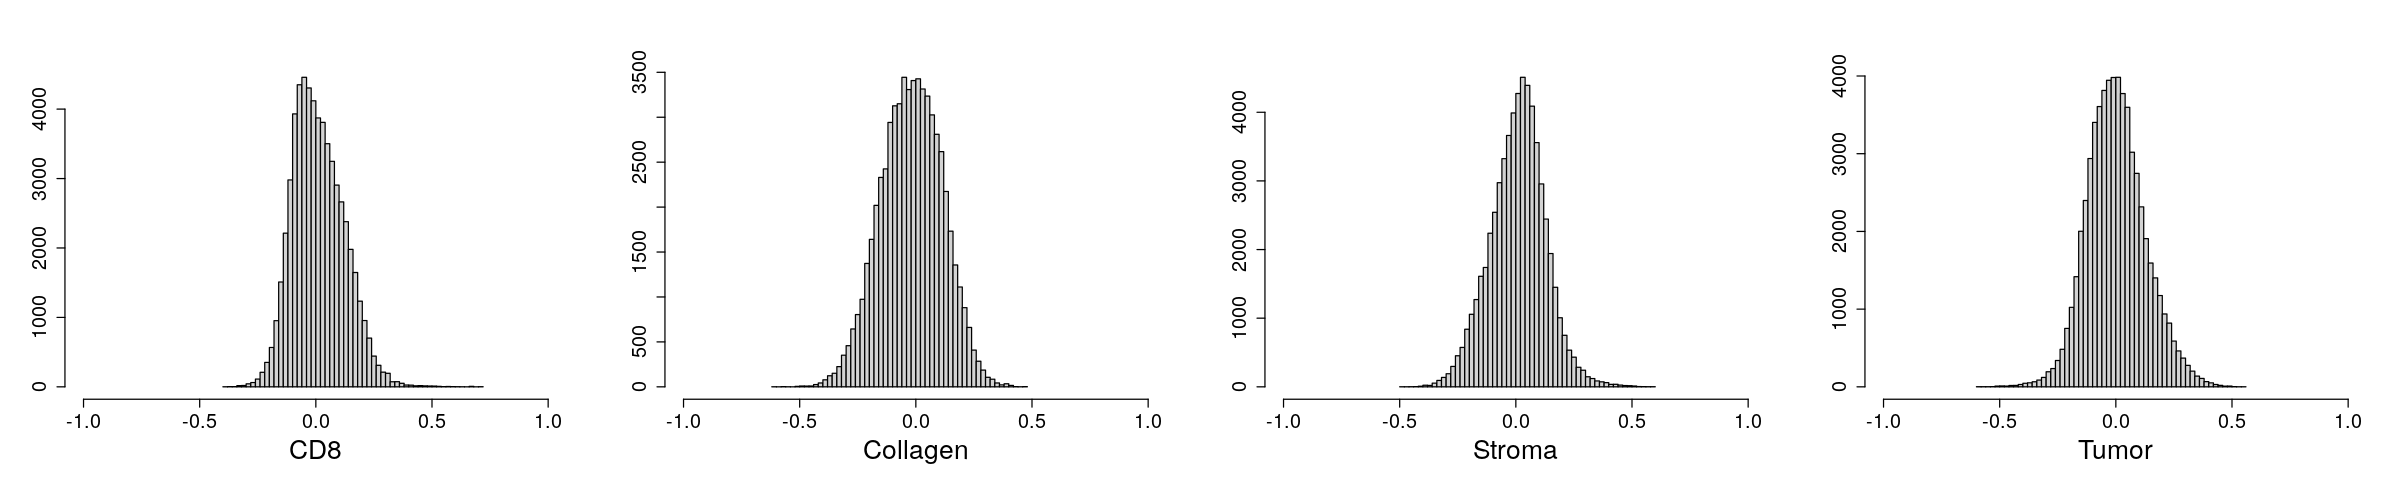

In [11]:
# Calculate Spearman correlations with all other columns
correlations <- cor(x = t(cts),
                    y = densities,
                    method = correlation_method) |>
  as.data.frame()

# Draw the histogram of the correlations for all the densities
options(repr.plot.width = 20, repr.plot.height = 4)
par(mfrow = c(1, 4))

for (i in seq_along(colnames(correlations))){
  hist(correlations[, i],
       xlim = c(-1, 1),
       ylab = "",
       xlab = colnames(correlations)[i],
       breaks = 50,
       main = "",
       cex.axis = 1.5,
       cex.lab = 2)
}

### Include only the marisome genes 
Using `Hs Matrisome Masterlist 2012` list we study the correlation between the immuno cells counts and the matrisome genes

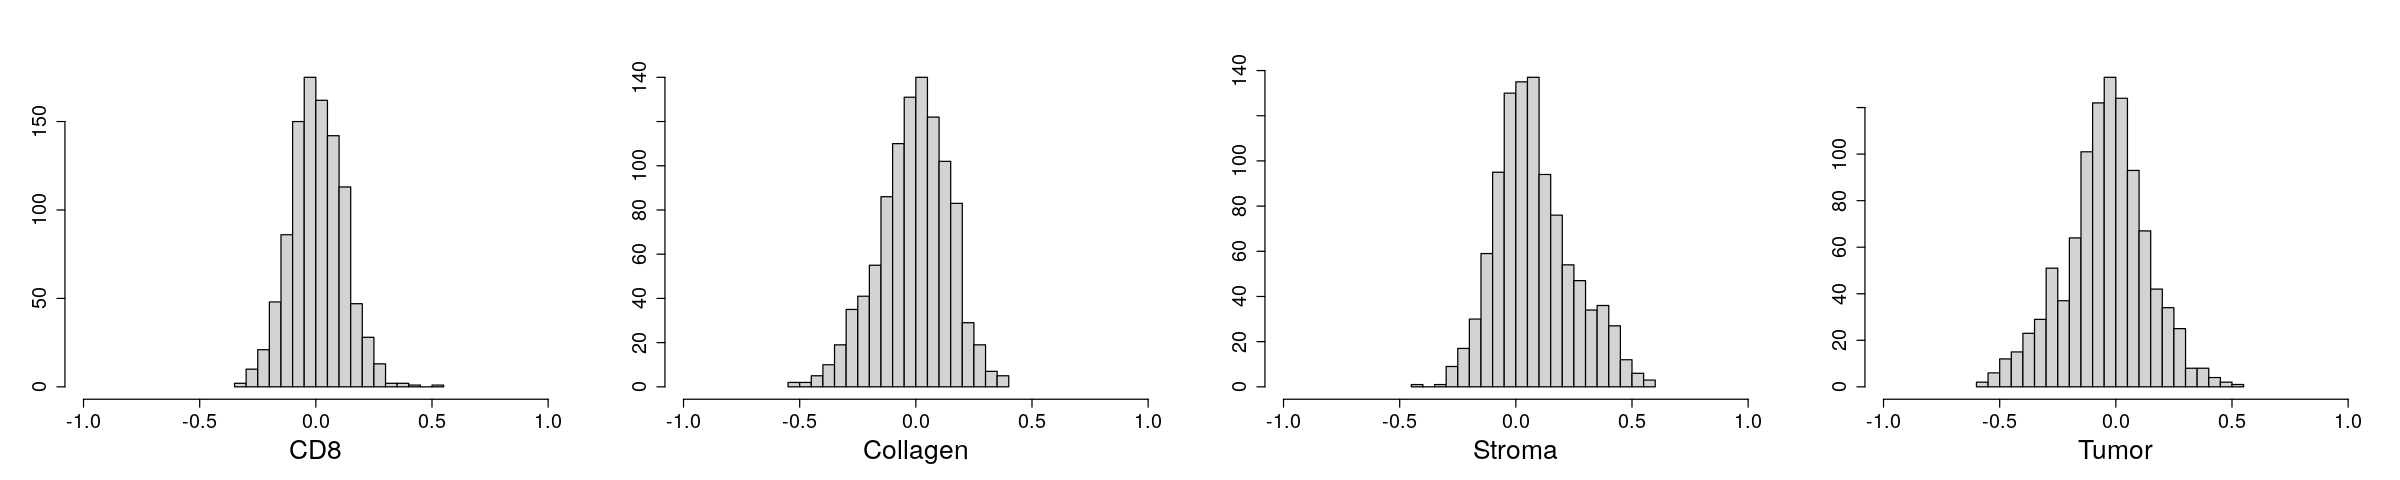

In [12]:
# Load the matrisome genes list
matrisome_genes <- read.csv("Hs_Matrisome_Masterlist_2012.csv")

# Take the correlation of the matrisome genes with the immune cell types
correlations_matrisome <- correlations[match(matrisome_genes$Gene.Symbol, gene_symbols) |> na.omit(), ]

# Draw the histogram of the correlations for all the densities
options(repr.plot.width = 20, repr.plot.height = 4)
par(mfrow = c(1, 4))

for (i in seq_along(colnames(correlations_matrisome))){
  hist(correlations_matrisome[, i],
       xlim = c(-1, 1),
       ylab = "",
       xlab = colnames(correlations_matrisome)[i],
       breaks = 20,
       main = "",
       cex.axis = 1.5,
       cex.lab = 2)
}

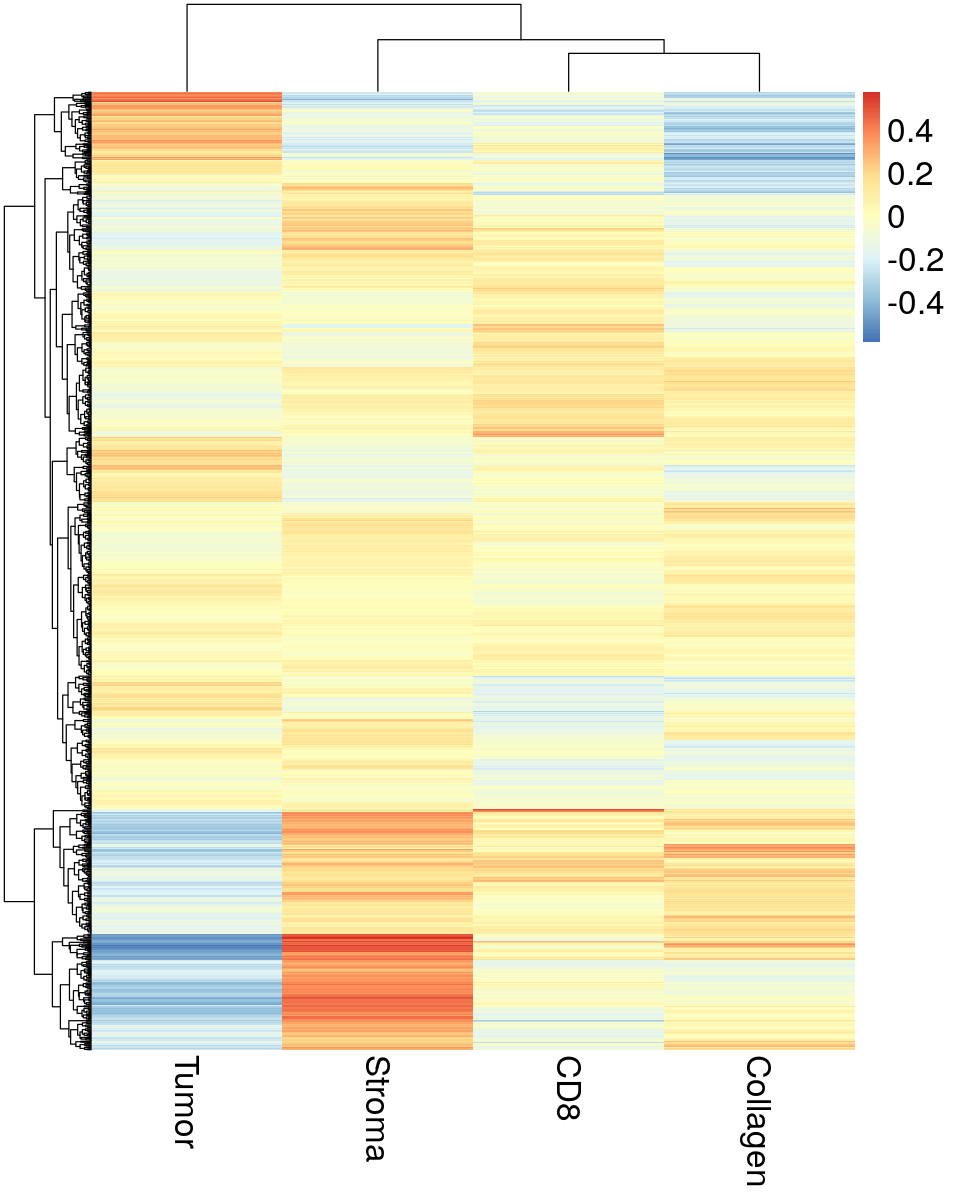

In [13]:
# Draw a heatmap of the correlations
options(repr.plot.width = 8, repr.plot.height = 10)
correlations_matrisome |> na.omit() |>
  pheatmap(show_rownames = FALSE,
           fontsize = 20)

## Create a full table with the correlations and the matrisome genes properties

In [14]:
# Transform the gene ids into gene symbols using the annotation table
gene_symbols_corr <- geneannot$GeneName[match(matrisome_genes$Gene.Symbol, gene_symbols)]

# Get the matrisome genes that are in the correlation matrix
matrisome_genes_corr <- matrisome_genes[match(matrisome_genes$Gene.Symbol, gene_symbols_corr) |> na.omit(), ]

# Bind the matrisome genes with the correlations
table_all <- cbind(matrisome_genes_corr, correlations_matrisome)

# Change the rownames to the gene ids
rownames(table_all) <- rownames(correlations_matrisome)

# Remove the na values
correlations_matrisome <- correlations_matrisome |> na.omit()
table_all <- table_all |> na.omit()

# Export the results

In [15]:
# Add Gene.Id column to the data frames and reorder it to be the first column
immuno_counts <- immuno_counts |>
  rownames_to_column(var = "Microdissection")

correlations <- correlations |>
  rownames_to_column(var = "Gene.Id")

correlations_matrisome <- correlations_matrisome |>
  rownames_to_column(var = "Gene.Id")

table_all <- table_all |>
  rownames_to_column(var = "Gene.Id")

# Export the immune cell types counts
write.csv(immuno_counts,
          paste0("data/MALDI_IHC/results/immuno_counts_", normalization, ".csv"),
          row.names = FALSE)

# Export the genes correlations
write.csv(correlations,
          paste0("data/MALDI_IHC/results/correlations_", normalization, "_", correlation_method, ".csv"),
          row.names = FALSE)

# Export the matrisome genes correlations
write.csv(correlations_matrisome,
          paste0("data/MALDI_IHC/results/correlations_matrisome_", normalization, "_", correlation_method, ".csv"),
          row.names = FALSE)

# Export the full table
write.csv(table_all,
          paste0("data/MALDI_IHC/results/correlations_matrisome_full_", normalization, "_", correlation_method, ".csv"),
          row.names = FALSE)